In [47]:
import numpy as np 
import pandas as pd 

Read in the data from the csv's

In [48]:
# Begrenzt die eingelesenen Daten aif 500 Zeilen (Geschwindigkeit)
train_data = pd.read_csv('fraud/fraudTrain.csv', delimiter=',')
train_data.dataframeName = 'fraudTrain.csv'
test_data = pd.read_csv('fraud/fraudTest.csv', delimiter=',')
test_data.dataframeName = 'fraudTest.csv'

To get to know the data we're dealing with, we will first use the head function to look at its columns and its values. It consists of various columns specifying the transaction (date, credit card number, transaction number, etc.) and columns for the characteristical values of the merchant, such as name, job, gender and detailled geographical information. A binary value determines if the transaction was a fraud.

In [91]:
train_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,week,hour,month,day
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,1,0,1,Tuesday
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,1,0,1,Tuesday
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,1,0,1,Tuesday
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,1,0,1,Tuesday
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,1,0,1,Tuesday


We first need to explore the data to determine which method of classification to use. We will conduct this exploration on the entirety of our data, therefore concatenating our two dataframes. The info() function gives us information on the used data types.

In [50]:
combined_df = pd.concat([train_data, test_data])
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time              int64  
 20  merch_lat              float64
 21  merch_long             float64
 22  is_fraud           

Checking for null values reveals that we are working with sanitized data and no missing values anywhere.

In [51]:
combined_df.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

The shape command shows that we have 1852394 rows and 23 columns in both of our data sets combined.

In [55]:
combined_df.shape

(1852394, 25)

We will first start by wrangling the data to normalise information such as dates. We can also expand the data by extracting additional time information such as week and hour.

In [90]:
train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])
test_data['trans_date_trans_time'] = pd.to_datetime(test_data['trans_date_trans_time'])

train_data['month'] = train_data['trans_date_trans_time'].dt.isocalendar().week
test_data['month'] = test_data['trans_date_trans_time'].dt.isocalendar().week

train_data['week'] = train_data['trans_date_trans_time'].dt.isocalendar().week
test_data['week'] = test_data['trans_date_trans_time'].dt.isocalendar().week

train_data['day'] = train_data['trans_date_trans_time'].dt.day_name()
test_data['day'] = test_data['trans_date_trans_time'].dt.day_name()

train_data['hour'] = train_data['trans_date_trans_time'].dt.hour
test_data['hour'] = test_data['trans_date_trans_time'].dt.hour

combined_df = pd.concat([train_data, test_data])

By determining the percentage of fraud transactions, our dependent variable for classification, we can see that only 0,5% of all transactions are frauds in all of our data sets. This is a highly imbalanced dependent variable which can result in an inaccuracy of our training algorithm. A classification with an imbalanced dependent variable will favour the majority class, in our case "no fraud", since it always strives to achieve the best possible accuracy.

In [57]:
combined_df['is_fraud'].value_counts(normalize=True).mul(100)

0    99.478999
1     0.521001
Name: is_fraud, dtype: float64

The same command for our train data reveals that our it also has a highly imbalanced dependent variable and therefore requires balancing. We will use oversampling, since it does not dispose of any potentially useful data as undersampling does by discarding data of the majority dependent variable.

In [61]:
train_data['is_fraud'].value_counts(normalize=True).mul(100)

0    99.421135
1     0.578865
Name: is_fraud, dtype: float64

In order to characterise fraud, we will filter for all occurences of fraud and plot the data based on various variables.

<AxesSubplot:xlabel='category'>

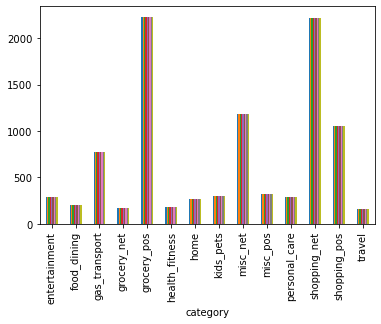

In [85]:
filtered_df = combined_df[combined_df.is_fraud == 1]
filtered_df = filtered_df[['gender', 'category', 'merchant', 'city', 'state', 'job', 'week', 'hour', 'month', 'trans_date_trans_time']]
filtered_df.groupby('category').count().plot(kind = 'bar', legend = False)